In [157]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F

In [158]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [159]:
#Hyper parameter
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 3

In [160]:
transform= transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

In [161]:
trainset = torchvision.datasets.KMNIST(
        root='./data', train=False,
        download=True, transform=transform,
    )

In [162]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True)

In [163]:
len(trainset)

10000

In [164]:
len(trainloader)

157

In [165]:
testset = torchvision.datasets.KMNIST(root='./data',train=False,
                                       download=True, transform=transform)

In [166]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

In [167]:
len(testloader)

157

In [168]:
len(testset)

10000

In [169]:
for image,label in trainloader:
    print(image.shape)
    print(label.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [170]:
for image,label in testloader:
    print(image.shape)
    print(label.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


**Neural Network**

In [171]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [172]:
class Net(nn.Module):

    def __init__(self):
        super(Net,self).__init__()
        self.fc1= nn.Linear(28*28, 512) # 28*28 from image dimension
        self.fc2= nn.Linear(512,128)
        self.fc3= nn.Linear(128,10)

    def forward(self, input):
        x= torch.flatten(input,1)
        x=self.fc1(x)
        x=F.relu(x)
        x=self.fc2(x)
        x=F.relu(x)
        x=self.fc3(x)
        return x

In [173]:
model= Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


Define Loss function & Optimizer

In [174]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.001)

**Trainning**

In [175]:
size = len(trainloader.dataset)
size

10000

In [176]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) #total number of image
    model.train()

    for batch, (image, label) in enumerate(dataloader):

        pred = model(image)
        loss = loss_fn(pred, label)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(image)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

**Testing**

In [177]:
size = len(testloader.dataset)
size

10000

In [178]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            pred = model(image)
            total_loss += loss_fn(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()

    total_loss /= num_batches
    correct /= size
    print(f"Test result: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {total_loss:>8f} \n")

Model

In [179]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1= nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
        )
        self.conv2= nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
        )
        self.conv3= nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.conv4= nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*6*6, 4096),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU()
        )
        self.fc3= nn.Sequential(
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x= self.conv1(x)
        x= self.conv2(x)
        x= self.conv3(x)
        x= self.conv4(x)
        x= self.conv5(x)
        x= x.reshape(x.shape[0], -1)
        x= self.fc1(x)
        x= self.fc2(x)
        x= self.fc3(x)
        return x

In [180]:
for epoch in range(1,4):
    print(f"Epoch {epoch}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test(testloader, model, loss_fn)

Epoch 1
-------------------------------
loss: 2.304283  [   64/10000]
loss: 2.292094  [ 6464/10000]
Test result: 
 Accuracy: 11.0%, Avg loss: 2.302073 

Epoch 2
-------------------------------
loss: 2.302210  [   64/10000]
loss: 2.300739  [ 6464/10000]
Test result: 
 Accuracy: 12.0%, Avg loss: 2.298257 

Epoch 3
-------------------------------
loss: 2.302732  [   64/10000]
loss: 2.297145  [ 6464/10000]
Test result: 
 Accuracy: 13.2%, Avg loss: 2.294448 



In [181]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


**Accuracy**

In [183]:
true_labels = [] #for confusion matrix
predicted_labels = [] #for confusion matrix

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy= 100 * correct / total
    print('Accuracy of the network on the 10000 test images: {} %'.format(accuracy))
    top1_error = 100 - accuracy
    print('Top-1 Error: {} %'.format(top1_error))

Accuracy of the network on the 10000 test images: 13.17 %
Top-1 Error: 86.83 %


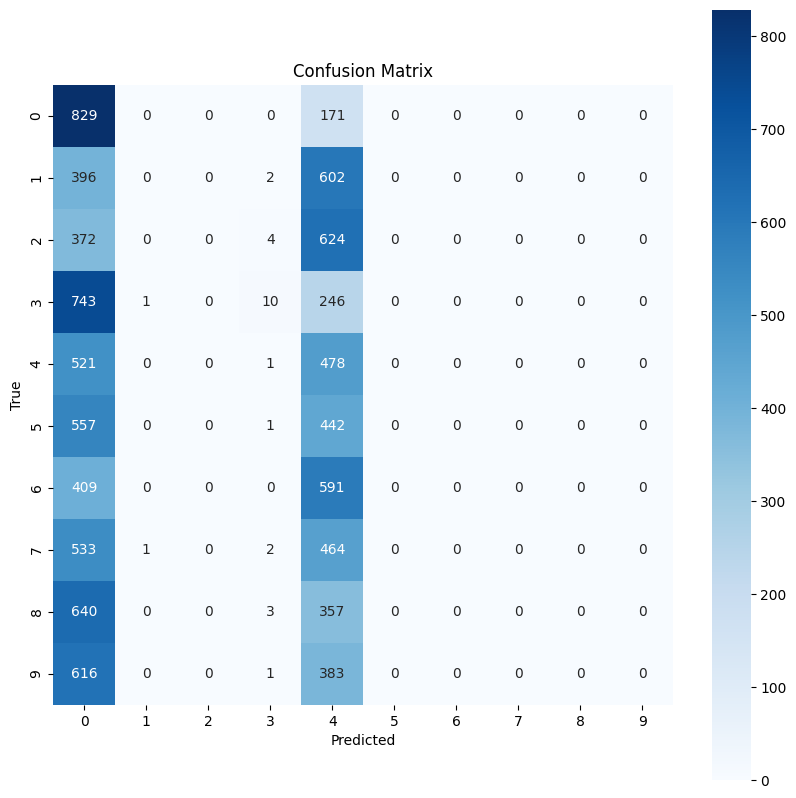

In [188]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(num_classes, num_classes))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', square=True, xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [191]:
import sklearn
report = sklearn.metrics.classification_report(true_labels, predicted_labels)
print('\n'+ report)


              precision    recall  f1-score   support

           0       0.15      0.83      0.25      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.42      0.01      0.02      1000
           4       0.11      0.48      0.18      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.13     10000
   macro avg       0.07      0.13      0.04     10000
weighted avg       0.07      0.13      0.04     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
